In [64]:
import seaborn as sns
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from scipy.signal import square, stft
from scipy import constants 
from scipy import signal, fftpack
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from DataLoader import *

In [2]:
sleepy_list = [11, 18, 0, 12, 10, 11, 5, 11, 2, 5, 9, 9, 17, 4, 2, 12, 12, 19, 13, 7, 11, 3, 5, 14, 14, 14, 12, 13, 11, 1, 11, 13, 11, 8, 19, 21, 22, 16, 15, 12, 26, 4, 19, 21, 18, 20]

sleepy_df = pd.DataFrame(sleepy_list)

sleepy_df["fatigue"] = sleepy_df[0]

sleepy_df = sleepy_df.drop(columns=0)

sleepy_df["is_tired"] = 0

sleepy_df['is_tired'] = (sleepy_df['fatigue'] > 11).astype(int)

<Axes: ylabel='Count'>

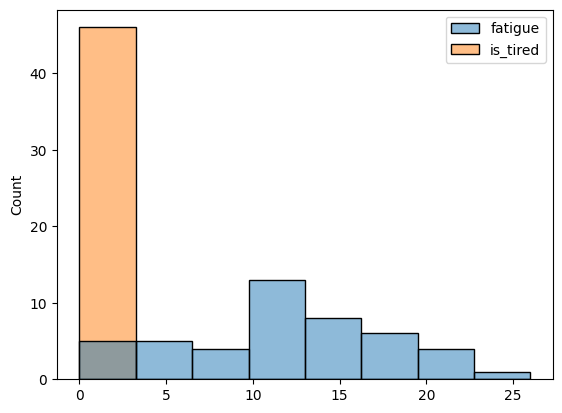

In [3]:
sns.histplot(sleepy_df)

In [67]:
def normalization(subject):
    num_transformer=make_pipeline(StandardScaler())
    num_transformer.fit(subject)
    return pd.DataFrame(num_transformer.transform(subject), columns=subject.columns)

In [69]:
df_list = []

for walk in range(0,46):
        df = pd.read_csv(f"data2/{walk}.csv", names = ["x",
        "y", "z"], dtype=float)
                # Load the time when the data measurement started from the first
                # value in the first row of the csv file
        starting_time = df.iloc[0, 0]
                # Load the data sampling rate from the first value in the second
                # row of the csv file
        sampling_rate = df.iloc[1, 0]
                # Removes the first two rows of the DataFrame, as they contain
                # info about the measurment starting time and sampling rate
        df = df.tail(-2).reset_index(drop=True)
                # Determine the number of samples in the data
        number_of_samples = len(df)
                # Generate the time vector based on the measurement starting time
                # and sampling rate
        time_vector = np.arange(starting_time, starting_time + 
            number_of_samples / sampling_rate, 1 / sampling_rate)
                #Add the UNIX time vector to the Pandas DataFrame
        df["UNIX_time"] = time_vector
                # Calculate the total duration of the DataFrame (in seconds)
        total_duration = df['UNIX_time'].max() - df['UNIX_time'].min()
                # Calculate the start time for the 30-minute window (center of data)
        half_duration = total_duration / 2
        center_time = df['UNIX_time'].min() + half_duration
                # Define the 30-minute window
        window_start = center_time - 900  # 900 seconds = 30 minutes
        window_end = center_time + 900
                # Extract data within a 30-minute window located at the center of
                # original DataFrame
        df = df[(df['UNIX_time'] >= window_start) & (df['UNIX_time'] <= window_end)]
                # Return the desired data as a Pandas DataFrame
        df = df.drop(columns='UNIX_time')
        df = df.reset_index(drop=True)
        df = normalization(df)

        df_list.append(df)

In [70]:
# Assuming each DataFrame has the same number of rows
# Convert the list of DataFrames to a 3D numpy array
X_tensor = np.array([df[['x', 'y', 'z']].values for df in df_list])

print(X_tensor.shape)  # Should print (46, number_of_rows, 3)

(46, 57600, 3)


In [71]:
sleepy_df.shape

(46, 2)

In [72]:
sleepy_df

,fatigue,is_tired
0,11,0
1,18,1
2,0,0
3,12,1
4,10,0
5,11,0
6,5,0
7,11,0
8,2,0
9,5,0


In [73]:
X_test = X_tensor[:10,:,:]
X_test.shape

(10, 57600, 3)

In [74]:
X_train = X_tensor[10:,:,:]
X_train.shape

(36, 57600, 3)

In [75]:
y_test = sleepy_df["is_tired"][:10]
y_test.shape

(10,)

In [76]:
y_train = sleepy_df["is_tired"][10:]
y_train.shape

(36,)

In [77]:
num_classes = len(np.unique(y_train))
num_classes

2

In [78]:
input_shape=X_train.shape[1:]


model = Sequential()

# 1D Convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Another 1D Convolutional layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM layer (without flattening)
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

# Another LSTM layer
model.add(LSTM(128))
model.add(Dropout(0.2))

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/Users/grozz/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)              │ (None, 57598, 64)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 28799, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 28799, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 28797, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 14398, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 14398, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 14398, 128)     │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14398, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,833 (1.13 MB)

 Trainable params: 296,833 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# on my lappie, this takes over 30 seconds per epoch!

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.3214 - loss: 0.7042 - val_accuracy: 0.8750 - val_loss: 0.6831
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.6429 - loss: 0.6781 - val_accuracy: 0.8750 - val_loss: 0.6603
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.7143 - loss: 0.6642 - val_accuracy: 0.8750 - val_loss: 0.6260
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.6071 - loss: 0.6564 - val_accuracy: 0.8750 - val_loss: 0.5991
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.5714 - loss: 0.6606 - val_accuracy: 0.8750 - val_loss: 0.5861
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.6071 - loss: 0.6317 - val_accuracy: 0.8750 - val_loss: 0.5767
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 0.7143 - loss: 0.6076 - val_accuracy: 1.0000 - val_loss: 0.5514
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.7500 - loss: 0.5802 - val_accuracy: 1.0000 - val_loss: 0.4804


In [82]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 1.4308


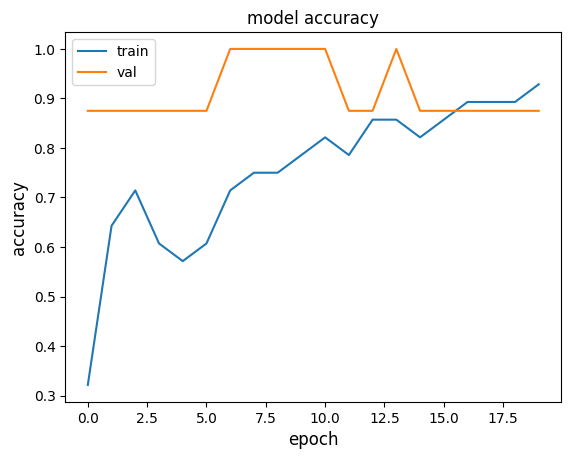

In [81]:
metric = "accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()